In [45]:
import pandas as pd
from common import (k_means_clustering, 
                    hierarchical_clustering,
                    gmm_clustering,
                    visualize_2d, 
                    visualize_3d)
import torch
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
import concurrent.futures

In [46]:
os.environ["LOKY_MAX_CPU_COUNT"] = "8"  # to avoid warning from sklearn  

## Read data

In [47]:
file_path = 'features.csv'
df = pd.read_csv(file_path)

In [48]:
additional_features = pd.read_csv('faces/csv/additional_features_margin_10%.csv')
# rename column filename
additional_features = additional_features.rename(columns={'filename': 'Image Name'})

df = df.merge(additional_features, on='Image Name')
df.head()

,Image Name,0,1,2,3,4,5,6,7,8,...,507,508,509,510,511,eyes_width,lips_width,eyes_lips_distance,angle_eyes_nose,angle_lips_nose
0,10003541_1937-09-27_1971.jpg,0.777451,0.011948,0.345767,1.477799,0.037944,0.455486,0.010915,1.241271,0.033868,...,0.453650,0.654318,1.072803,0.280445,0.029986,0.465768,0.406061,0.342520,1.548578,1.618201
1,10004299_1908-08-19_1950.jpg,0.158841,0.515599,0.492410,0.076235,0.049106,0.627977,0.110128,0.169187,0.079632,...,0.164485,0.199483,0.657470,0.243965,0.256589,0.474542,0.409263,0.357535,1.375667,1.617274
2,10005947_1981-04-07_2006.jpg,0.337588,0.846870,0.572446,3.319363,0.027718,0.026189,0.397696,0.960857,0.861962,...,0.191648,0.922814,0.591462,0.143617,0.208631,0.461045,0.393276,0.349658,1.489564,1.668123
3,1000781_1930-07-07_2008.jpg,0.051202,0.302977,0.622274,1.818456,0.206403,1.049190,0.499435,0.771295,0.025018,...,0.470243,0.159687,1.007972,0.000000,0.072699,0.466048,0.409249,0.388199,1.570796,1.430033
4,100131_1926-09-06_1986.jpg,0.771404,0.248878,0.517602,1.710205,0.129466,0.463290,0.333639,1.558523,0.074622,...,0.593846,0.239708,0.566813,1.559201,0.181968,0.450536,0.377545,0.359166,1.403826,1.440760


In [49]:
# add features as column

df['tensor'] = [torch.tensor(x, dtype=torch.float32) for x in df.drop(columns=['Image Name']).values]

In [50]:
df = df[['Image Name', 'tensor']]

In [51]:
df.head()

,Image Name,tensor
0,10003541_1937-09-27_1971.jpg,"[tensor(0.7775), tensor(0.0119), tensor(0.3458..."
1,10004299_1908-08-19_1950.jpg,"[tensor(0.1588), tensor(0.5156), tensor(0.4924..."
2,10005947_1981-04-07_2006.jpg,"[tensor(0.3376), tensor(0.8469), tensor(0.5724..."
3,1000781_1930-07-07_2008.jpg,"[tensor(0.0512), tensor(0.3030), tensor(0.6223..."
4,100131_1926-09-06_1986.jpg,"[tensor(0.7714), tensor(0.2489), tensor(0.5176..."


## Clustering

In [52]:
tensor_list = df['tensor'].tolist()
features = torch.stack(tensor_list)

In [61]:
# normalize features
features = (features - features.mean(dim=0)) / features.std(dim=0)

In [71]:
N_CLUSTERS = 5
CLUSTERING_METHOD = 'kmeans'
labels = None
if CLUSTERING_METHOD == 'kmeans':
    labels = k_means_clustering(features, N_CLUSTERS)
elif CLUSTERING_METHOD == 'hierarchical':
    labels = hierarchical_clustering(features, N_CLUSTERS)
elif CLUSTERING_METHOD == 'gmm':
    labels = gmm_clustering(features, N_CLUSTERS)
else:
    raise ValueError(f'Invalid clustering method: {CLUSTERING_METHOD}')

In [72]:
# find centroids
centroids = []
for i in range(N_CLUSTERS):
    cluster = features[labels == i]
    centroid = cluster.mean(dim=0)
    centroids.append(centroid)

In [56]:
def compute_silhouette_score(n_clusters):
    k_means_labels = k_means_clustering(features, n_clusters)
    k_means_silhouette_score = silhouette_score(features, k_means_labels)

    hierarchical_labels = hierarchical_clustering(features, n_clusters)
    hierarchical_silhouette_score = silhouette_score(features, hierarchical_labels)

    return max(k_means_silhouette_score, hierarchical_silhouette_score)

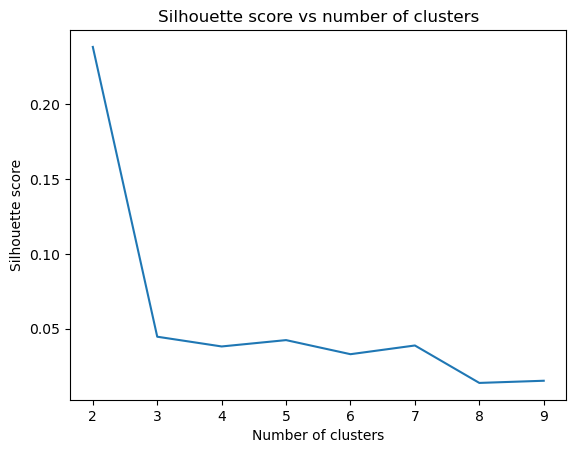

In [57]:
silhouette_scores = []
with concurrent.futures.ThreadPoolExecutor() as executor:
    for score in executor.map(compute_silhouette_score, range(2, 10)):
        silhouette_scores.append(score)

plt.plot(range(2, 10), silhouette_scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title('Silhouette score vs number of clusters')
plt.show()

## Visualization

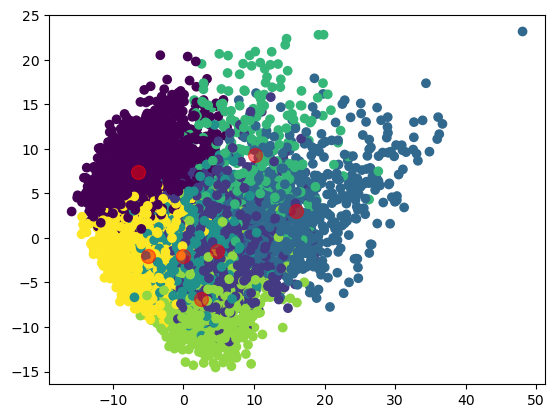

In [36]:
visualize_2d(features, centroids, labels)

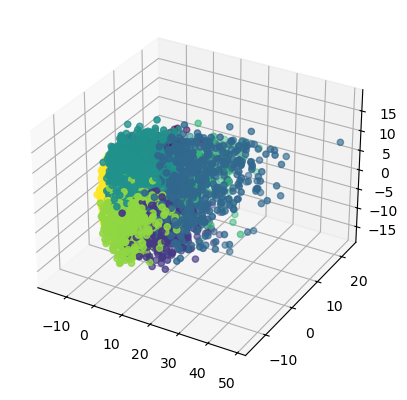

In [37]:
visualize_3d(features, centroids, labels)

## Get samples from each cluster

In [73]:
images_folder = './data/images/'

In [74]:
def plot_images(images, labels, images_folder):
    n = len(images)
    nrows = int(np.ceil(n / 5))
    fig, axs = plt.subplots(nrows, 5, figsize=(15, 3 * nrows))
    axs = axs.ravel()  # flatten the array to easily iterate over it
    for i, (img_name, label) in enumerate(zip(images, labels)):
        img = cv2.imread(os.path.join(images_folder, img_name))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axs[i].imshow(img)
        axs[i].set_title(f'Cluster {label}')
        axs[i].axis('off')
    # remove the axes of the extra subplots
    if n % 5 != 0:
        for j in range(n, nrows * 5):
            fig.delaxes(axs[j])
    plt.tight_layout()
    plt.show()

In [75]:
# add labels to df
df['labels'] = labels

In [76]:
df.head()

,Image Name,tensor,labels
0,10003541_1937-09-27_1971.jpg,"[tensor(0.7775), tensor(0.0119), tensor(0.3458...",4
1,10004299_1908-08-19_1950.jpg,"[tensor(0.1588), tensor(0.5156), tensor(0.4924...",1
2,10005947_1981-04-07_2006.jpg,"[tensor(0.3376), tensor(0.8469), tensor(0.5724...",4
3,1000781_1930-07-07_2008.jpg,"[tensor(0.0512), tensor(0.3030), tensor(0.6223...",1
4,100131_1926-09-06_1986.jpg,"[tensor(0.7714), tensor(0.2489), tensor(0.5176...",2


In [77]:
# get samples from each cluster
sample_count = 5
samples = []
for i in range(N_CLUSTERS):
    from_cluster = df[df['labels'] == i].copy()  # create a copy to avoid warnings
    from_cluster = from_cluster[
        from_cluster['Image Name'].apply(lambda x: os.path.exists(os.path.join(images_folder, x)))]
    from_cluster.loc[:, 'distance'] = from_cluster['tensor'].apply(lambda x: torch.dist(x, centroids[i]))
    from_cluster = from_cluster.sort_values(by='distance')
    samples.append(from_cluster.head(sample_count))

samples_df = pd.concat(samples)

In [78]:
samples_df

,Image Name,tensor,labels,distance
7736,704258_1953-01-15_1990.jpg,"[tensor(0.), tensor(0.9675), tensor(0.4405), t...",0,tensor(18.0327)
5864,40348617_1907-02-09_1941.jpg,"[tensor(0.), tensor(0.3603), tensor(1.2012), t...",0,tensor(18.6923)
2637,22280011_1926-09-11_1940.jpg,"[tensor(0.1768), tensor(0.5970), tensor(0.3923...",0,tensor(18.6984)
5175,36381948_1985-11-21_2012.jpg,"[tensor(0.0512), tensor(1.0506), tensor(0.1280...",0,tensor(18.7658)
373,1152622_1964-06-21_2009.jpg,"[tensor(0.0996), tensor(0.4948), tensor(0.4557...",0,tensor(18.8772)
8057,7978760_1976-12-20_2008.jpg,"[tensor(0.0849), tensor(0.4097), tensor(0.5036...",1,tensor(16.0695)
1238,1562709_1973-11-13_2008.jpg,"[tensor(0.2303), tensor(0.1024), tensor(0.6408...",1,tensor(16.7031)
596,12459501_1981-01-13_2013.jpg,"[tensor(0.), tensor(0.3914), tensor(0.4304), t...",1,tensor(16.8176)
405,11646425_1975-11-13_2011.jpg,"[tensor(0.), tensor(0.7920), tensor(0.3005), t...",1,tensor(17.0661)
2714,2261965_1962-11-14_2013.jpg,"[tensor(0.0568), tensor(0.2400), tensor(0.8485...",1,tensor(17.8278)


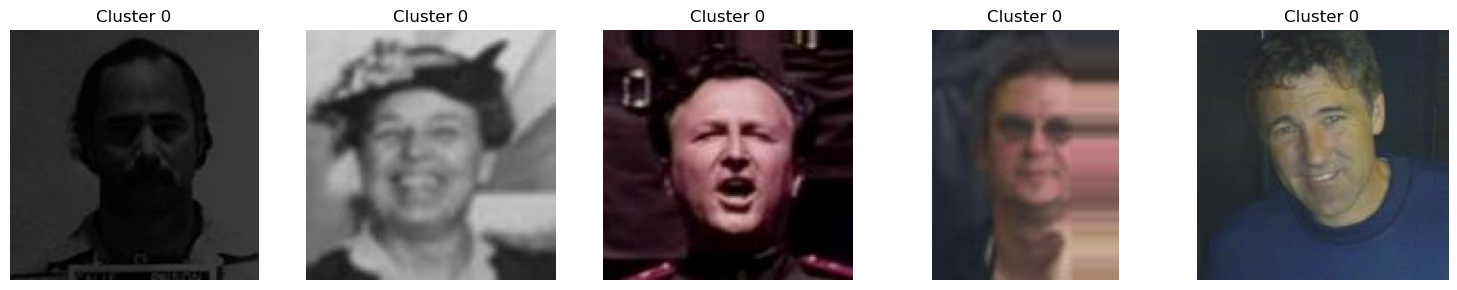

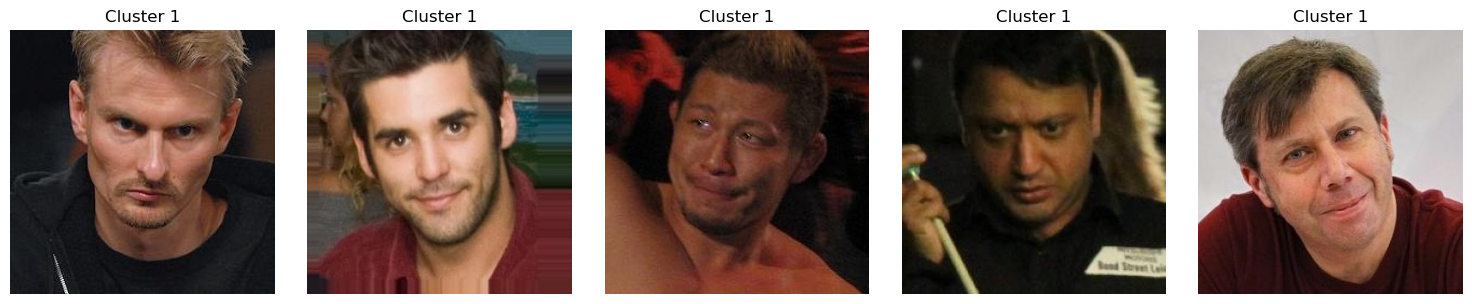

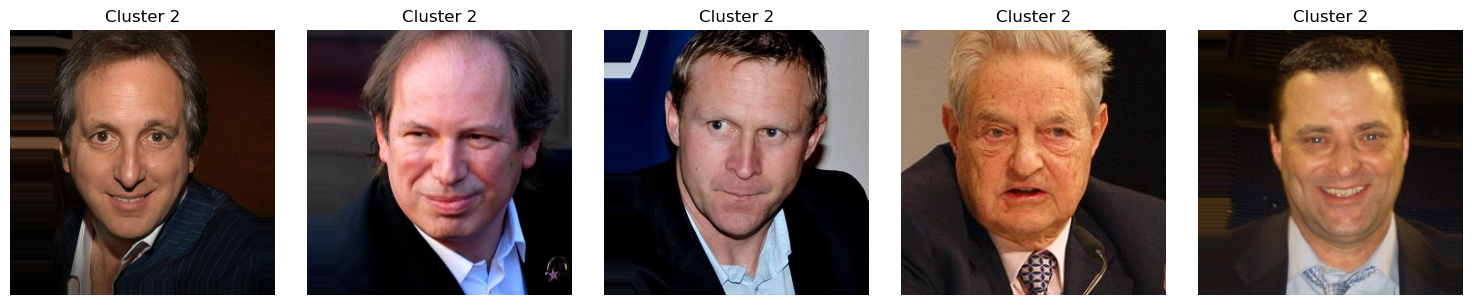

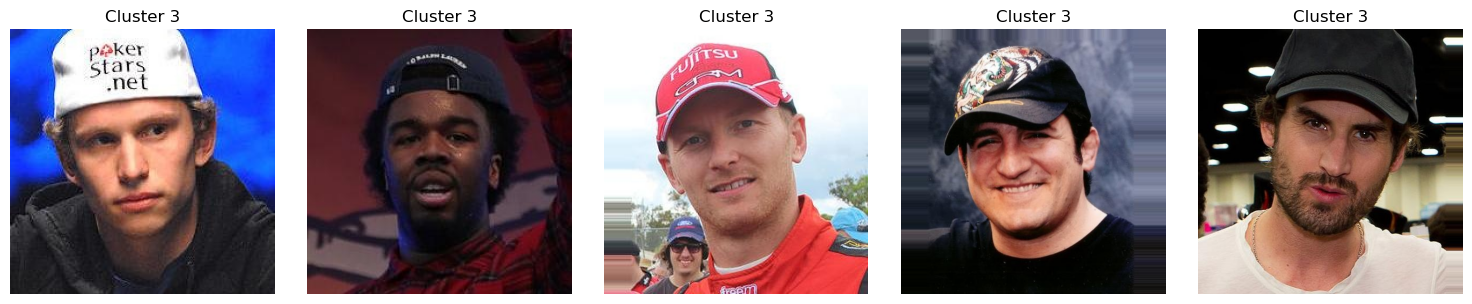

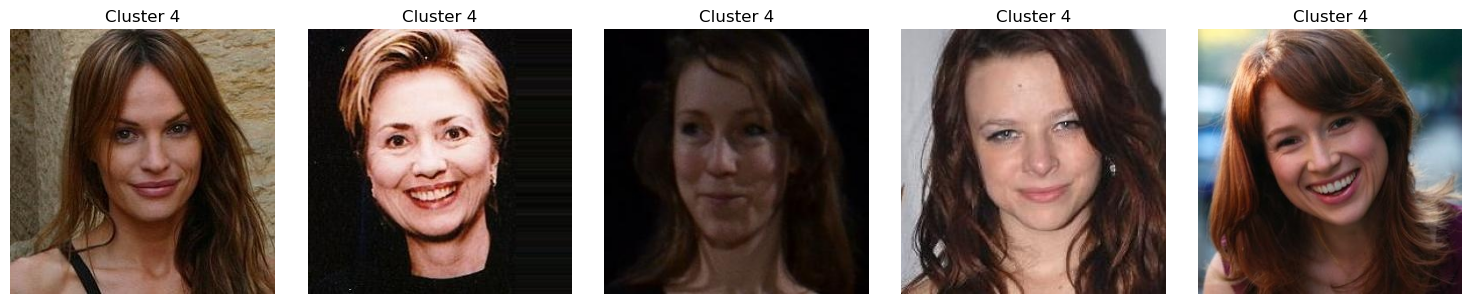

In [79]:
# plot samples for each cluster
for i in range(N_CLUSTERS):
    cluster_samples = samples_df[samples_df['labels'] == i]
    plot_images(cluster_samples['Image Name'].values, cluster_samples['labels'].values, images_folder)